<a href="https://colab.research.google.com/github/LinjingBi/practice-nn-0-to-hero/blob/master/L1_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Value class is a scalar class - 0 D tensor.

In [84]:
import numpy as np
import math
import matplotlib.pyplot as plt

class Value:
    def __init__(self, data, _children=set(), _op='', label=''):
      self.data = data
      self._prev = set(_children) # has to be set to revent cases like b=a+a
      self._op = _op
      self.label = label
      self.grad = 0.0
      self._backward = lambda: None

    def __repr__(self):
      return f"Value(data={self.data}, label={self.label})"
    def __add__(self, other):
      other = other if isinstance(other, Value) else Value(other)  # support other as an integer
      out = Value(self.data + other.data, (other, self), '+')
      def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
      out._backward = _backward
      return out
    def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other) # support other as an integer
      out = Value(self.data * other.data, (other, self), '*')
      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
      out._backward = _backward
      return out
    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self,), _op='tanh')
      def _backward():
        self.grad += (1 - t**2)*out.grad
      out._backward = _backward
      return out
    def exp(self):
      out = Value(math.exp(self.data),(self, ), _op='exp')

      def _backward():
        self.grad += out.data*out.grad

      out._backward = _backward
      return out

    def __sub__(self, other): # self - other, in such case, otehr can be an integer, instead a Value obj
      return self + (-other)

    def __neg__(self):
      # return (-1) * self
      return self * (-1)

    def __rmul__(self, other):  # other * self, in such case, otehr can be an integer, instead a Value obj
      return self * other

    def __radd__(self, other):  # other + self, in such case, otehr can be an integer, instead a Value obj
      return self + other

    def __pow__(self, other):
      # why Integer other, not Value other?
      # it is only for simplicity, because if the power is a Value, _backward(derivative) is going to include self.grad and other.grad f.e.
      # self.grad = other.data * (self.data ** (other.data - 1)), not much different.
      # other.grad = (self.data ** other.data) * ln(other.data), since other is a Value, we also need to upgrade its grad in _backward.
      assert isinstance(other, (int, float)), "only support int/float power"
      out = Value(self.data ** other, (self,), _op=f'** {other}')

      def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward

      return out

    def __truediv__(self, other):
      return self * (other ** -1)

    def backward(self):
      # backward gradient
      visited = set()
      child = []
      # collect child points
      def find_topo(v):
        if v not in visited:
          visited.add(v)
          for nxt in v._prev:
            find_topo(nxt)
          child.append(v)

      find_topo(self)

      self.grad = 1.0  # !!!don't forget to init grad to 1
      for c in child[::-1]:
        c._backward()




Function for drawing dataflow between Values

In [85]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(n):
        if n not in nodes:
            nodes.add(n)
            for child in n._prev:
                edges.add((child, n))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(node):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(node)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{ %s | Data %.4f | Grad %.4f }' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid+n._op, label=f'{n._op}')
            dot.edge(uid+n._op, uid)
    for e_l, e_r in edges:
        dot.edge(str(id(e_l)), str(id(e_r))+e_r._op)
    return dot

Build forward dataflow and also calculate backward gradients.

In [86]:
# mini neural network
"""
x1 ->|
     |X1W1+X2W2+b| -> tanh -> out
x2 ->|

"""
x1 = Value(data=2, label='x1')
w1 = Value(data=-3, label='w1')
x2 = Value(data=0, label='x2')
w2 = Value(data=1, label='w2')

x1xw1 = x1*w1; x1xw1.label = 'x1*w1'
x2xw2 = x2*w2; x2xw2.label = 'x2*w2'

j = x1xw1 + x2xw2; j.label = 'x1*w1 + x2*w2'

b = Value(data=6.8813735870195432, label='b')
h = j + b; h.label = 'h'

# use Value.tanh directly
# o = h.tanh(); o.label = 'o'; o.grad = 1.0
# o.data is 0.7071

# construct tanh manually
o = ((2*h).exp() - 1) / ((2*h).exp() + 1); o.lable = 'o'; o.grad = 1.0
o.backward()

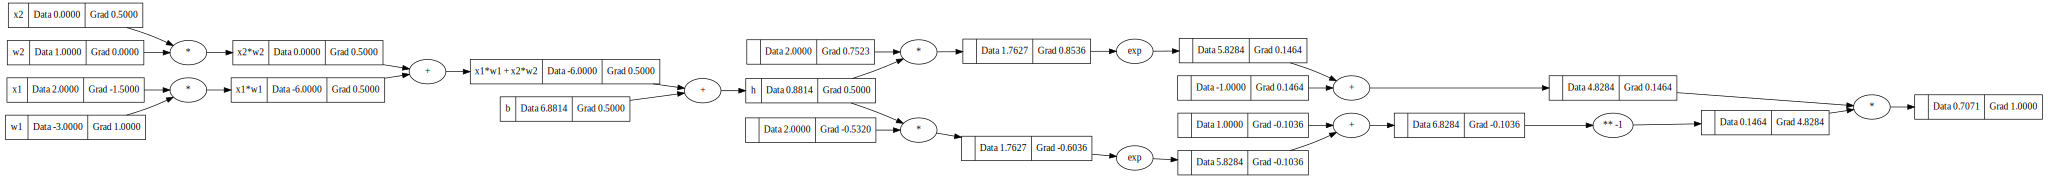

In [87]:
draw_dot(o)

Below is create scalars using tensor from Pytorch. And replicate the same dataflow with tensor and also calculate the backward gradients of these tensors.


In [88]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True

h = x1*w1 + x2*w2 + b  # note tensor h doesn't require gradient, h.grad is None. But its gradient was definitely calculated as part of the chain rule.
e = h.tanh() # so does e
e.backward()

print(e.data.item())
print('----')
print("x1.grad", x1.grad.item())
print("x2.grad", x2.grad.item())
print("w1.grad", w1.grad.item())
print("w2.grad", w2.grad.item())


0.7071066904050358
----
x1.grad -1.5000003851533106
x2.grad 0.5000001283844369
w1.grad 1.0000002567688737
w2.grad 0.0


Now lets get back to Value, and use it to create Neuro, Layer, MLP.

In [89]:
import random

class Module:

  def parameters(self):
    # overwrite!!
    return []

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0.0


class Neuro(Module):
  """
  computation unit:

  inputs -> |weights*inputs + bias| -> activation func -> out

  so three things from one neuro: weights, bias, activation func
  """

  def __init__(self, nin):
    """
    define weights and bias base on input number:
      one input one weight, one neuro one bias
    nin: number of the inputs that go into the neuro
    """
    self.w = [Value(random.uniform(-1, 1)) for n in range(nin)] # a list of Value objs
    self.b = Value(random.uniform(-1, 1))  # a Value obj
  def __call__(self, inputs):
    """
    give neuro output by first of all performing inputs*weights + bias, then a non-linear activation func(tanh here).
    inputs: a list of Value objs/ or just a list of numbers, because in Value.__mul__(other), we can have "other" in non-Value type.
    out: a Value obj

    kick off the computation
    """

    act = sum((w*x for w, x in zip(self.w, inputs)), start=self.b)
    out = act.tanh()

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer(Module):
  """
  Layer is a series of neuros, f.e.
             neuro_1
  inputs     neuro_2
               ...
  """

  def __init__(self, nin, nouts):
    """
    construct layer: a list of neuros.
    """
    self.neuros = [Neuro(nin) for _ in range(nouts)]

  def __call__(self, inputs):
    """
    kick off(call) all the neuros in this layer
    """
    outs = [neuro(inputs) for neuro in self.neuros]
    return outs

  def parameters(self):
    return [p for n in self.neuros for p in n.parameters()]

class MLP(Module):
  """
  Multi layer perceptron, f.e.
             neuro_11     neuro_21
  inputs     neuro_12     neuro_22   ...
               ...          ...
  ----------------------------------
  a network needs to know the # of input, # of layer and # of neuro per layer.

  """
  def __init__(self, nin, nouts):
    """
    nin: number of inputs
    nouts: a list of integer, f.e. [1,2,3]. len(nouts) - number of layers in MLP. nouts[i] - number of neuros(the number of outputs) in layer i.
    """
    layers = [nin] + nouts
    self.layers = [Layer(layers[i], layers[i+1]) for i in range(len(nouts))]

  def __call__(self, inputs):
    """
    kick off(call) the layers in this MLP
    """
    x = inputs
    for layer in self.layers:
      x = layer(x)

    return x  # return MLP final outputs

  def parameters(self):
    return [p for l in self.layers for p in l.parameters()]



[Value(data=-0.4749878447805571, label=q), Value(data=0.28584922745581, label=t)]


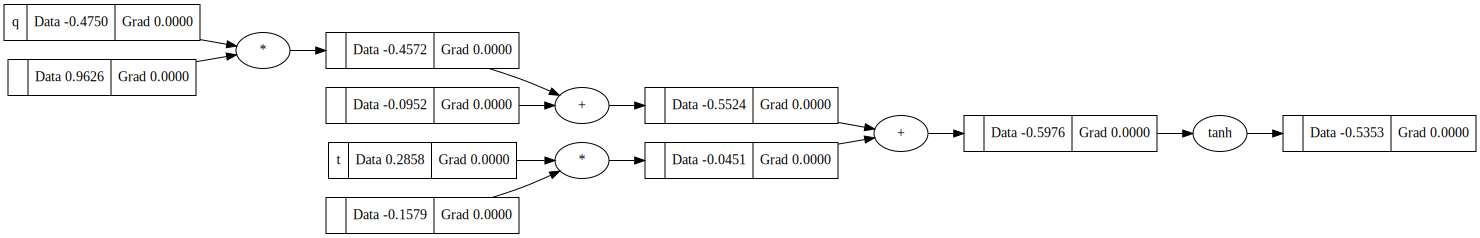

In [90]:
## lets try init a 2 inputs, 1 hidden layers neuro network
import string
import random

nint = 2
input_labels = random.sample(string.ascii_lowercase, nint)
inputs = [Value(random.uniform(-1, 1), label=input_labels[i]) for i in range(nint)]
print(inputs)
nlayers = [2]

nn = MLP(len(inputs), nlayers)
outs = nn(inputs)


draw_dot(outs[0])

In [91]:
# model params
inputs_shape = (4, 3)  # 4 is batch size, 3 is epoch size
layer_shape = [3, 4, 5, 6] # 4 layer, each with 3, 4, 5, 6 number of neuro

In [112]:
# Now, lets build a more complex NN and test it with multiple inputs
def build_model(nin, layer_shape):
  return MLP(nin=nin,
             nouts=layer_shape)

# due to generate random inputs and outputs, sometime cannot converge...
def create_batch(batch_size, input_size, output_size):
  inputs = [random.choices([3,-1,3,0.5,1], k=input_size) for _ in range(batch_size)]
  ys_expected = [p for p in random.choices([1, -1], k=output_size) for _ in range(batch_size)]

  return inputs, ys_expected


def train(model, inputs, ys_expected):
  # forward pass
  ys_hat = [p for input in inputs for p in model(input)]
  # loss
  loss = sum((y_h - y_e) ** 2 for y_h, y_e in zip(ys_hat, ys_expected))
  # zero gradients
  model.zero_grad()
  # backward gradient descent
  loss.backward()
  for p in model.parameters():
    p.data = p.data - 0.1*p.grad


model = build_model(inputs_shape[1], layer_shape)
inputs, ys_expected = create_batch(inputs_shape[0], inputs_shape[1], layer_shape[-1])
print(f"Expected: {ys_expected[:layer_shape[-1]]}")

for _ in range(50):
  train(model, inputs, ys_expected)
print(model(inputs[0]))



[[3, 3, 3], [-1, -1, 3], [1, 3, 0.5], [0.5, -1, -1]]
Expected: [-1, -1, -1, -1, 1, 1]
[Value(data=0.060032904940682356, label=), Value(data=0.02798170941222967, label=), Value(data=0.05716545513303159, label=), Value(data=0.03363076737453407, label=), Value(data=0.9901239017092056, label=), Value(data=0.9883133857466925, label=)]
